<a href="https://colab.research.google.com/github/jyoti17github/EIP3_PHASE_2/blob/master/Assignment_1_EIP_Phase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradcam applied on cifar 10 dataset
## Note - here removed flatten layer and applied GAP to get clear view of Gradcam 

### Importing libraries to perform convolution operations

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout , GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

### loading cifar10 dataset and creating training and test dataset variables

In [8]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


### Cifar has 10 classes - traversing dataset and printing 10 classes images

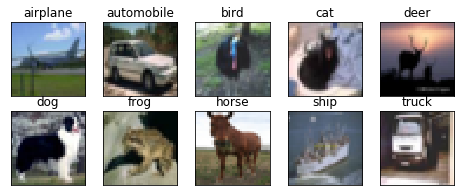

In [10]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Plot model accuracies and losses

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### Functions  predict test dataset and calculate accuracy, get_random_eraser

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)


### Converting image values to float type and assigning lables 

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Defining Model and adding image Augmentation cutout -


In [0]:
# Define the model
model = Sequential()

model.add(Conv2D(64, (3,3), name='layer2344', padding="same", input_shape=(32, 32, 3))) #RF 3x3
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(Conv2D(128, (3, 3),  name="layer2",padding="same")) #RF 5x5
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size=(2, 2))) #RF 10x10


model.add(Conv2D(256, (3, 3), padding='same',name='layer3'))  #RF 12x12
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Conv2D(512, (3, 3), padding='same', name='layer4'))  #RF 14x14
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(MaxPooling2D(pool_size=(2, 2)))  #RF 28x28

model.add(Conv2D(128, (3, 3), padding='same', name='layer5'))  #RF 30x30
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Conv2D(256, (3, 3), padding='same', name='layer6')) 
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3), padding='same', name='layer7'))  
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Conv2D(10, (1, 1), padding='same', name='layer7'))
model.add(GlobalAveragePooling2D())

# model.add(Flatten())

model.add(Activation('softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

W0717 06:40:23.788887 139812997801856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 06:40:23.806139 139812997801856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 06:40:23.808944 139812997801856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0717 06:40:23.836929 139812997801856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0717 06:40:23.837843 1398129978

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer2344 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
layer2 (Conv2D)              (None, 32, 32, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0         
__________

# datagenerator with default augmentaion 

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

In [0]:
checkpoint = ModelCheckpoint('/content/drive/My Drive/EVA_Phase1/BestModel_9A.hdf5',monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

## Run model for 50 epochs and visualize model accuracy( validation and training)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  
W0717 06:40:25.373452 139812997801856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a fu

Epoch 1/50
390/390 [==============================] - 41s 104ms/step - loss: 1.1196 - acc: 0.6014 - val_loss: 1.2270 - val_acc: 0.5927
Epoch 2/50
390/390 [==============================] - 37s 95ms/step - loss: 0.6851 - acc: 0.7602 - val_loss: 0.9216 - val_acc: 0.6922
Epoch 3/50
390/390 [==============================] - 36s 92ms/step - loss: 0.5272 - acc: 0.8180 - val_loss: 0.7067 - val_acc: 0.7562
Epoch 4/50
390/390 [==============================] - 36s 92ms/step - loss: 0.4361 - acc: 0.8479 - val_loss: 0.7947 - val_acc: 0.7435
Epoch 5/50
390/390 [==============================] - 36s 92ms/step - loss: 0.3620 - acc: 0.8740 - val_loss: 0.6573 - val_acc: 0.7754
Epoch 6/50
390/390 [==============================] - 36s 92ms/step - loss: 0.2980 - acc: 0.8967 - val_loss: 0.7296 - val_acc: 0.7660
Epoch 7/50
390/390 [==============================] - 36s 92ms/step - loss: 0.2527 - acc: 0.9115 - val_loss: 0.6897 - val_acc: 0.7787
Epoch 8/50
390/390 [==============================] - 36s 92m

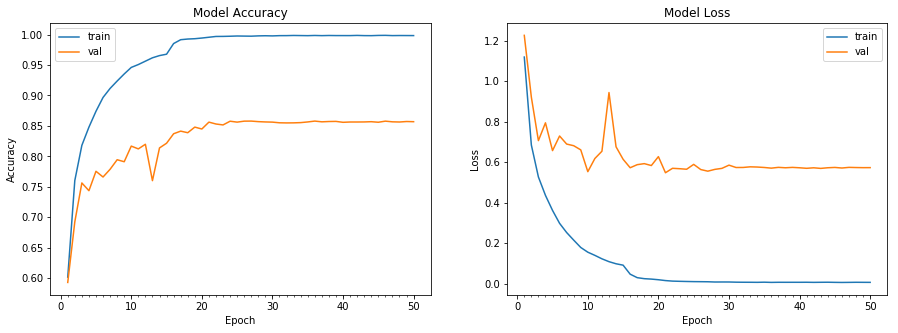

Accuracy on test data is: 85.69


In [0]:
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1,
                                 callbacks=callbacks)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [3]:
model = load_model('/content/drive/My Drive/EVA_Phase1/BestModel_9A.hdf5')

W0717 16:37:50.675616 140586473428864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 16:37:50.739850 140586473428864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0717 16:37:50.805463 140586473428864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 16:37:50.806460 140586473428864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0717 16:37:50.807770 140586473

## Here use predict generator to find misclassify images

In [14]:
predictY = model.predict_generator(datagen.flow(test_features, test_labels,shuffle=False, batch_size = 128),steps=len(test_features)/128)
print(predictY.shape)

y_pred_max = np.argmax(np.rint(predictY), axis=1)
print(y_pred_max)
y_max = np.argmax(np.rint(test_labels), axis=1)
print(y_max.shape[0])
print(y_max)
index= []
#if lables of predicted and test labels are not matched means -those are misclassified
for x in range(y_pred_max.shape[0]):
  if y_pred_max[x] != y_max[x]:
    index.append(x)
 
print(len(index))

(10000, 10)
[3 8 8 ... 5 1 7]
10000
[3 8 8 ... 5 1 7]
1475


## Show mis classify images - 50 counts

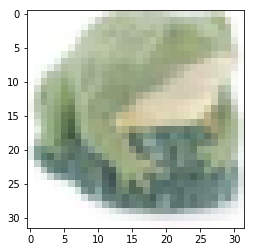

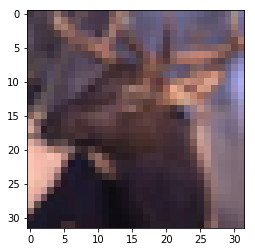

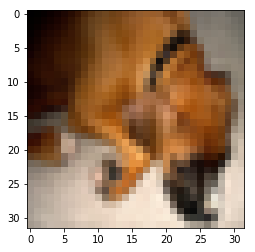

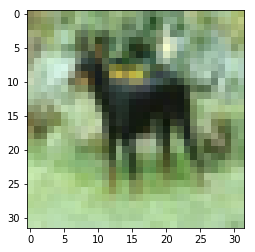

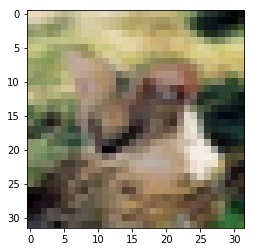

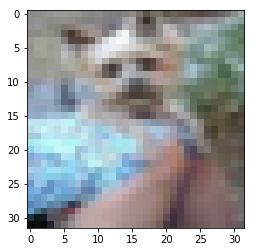

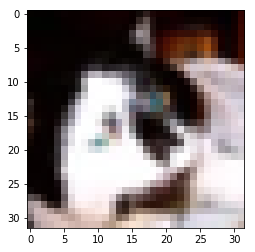

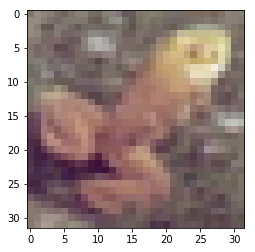

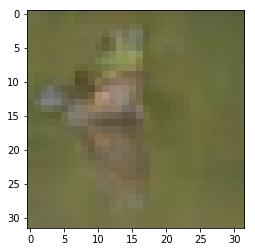

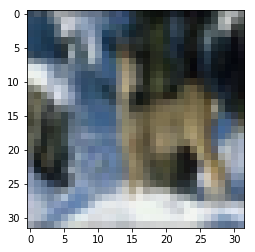

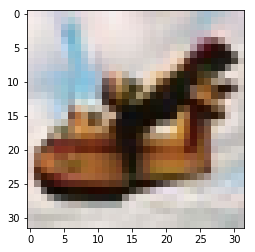

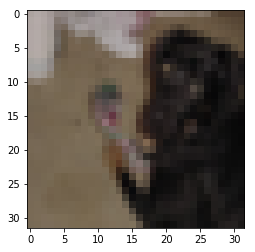

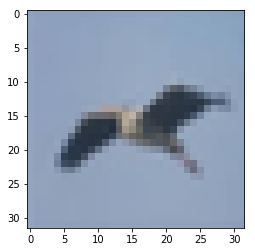

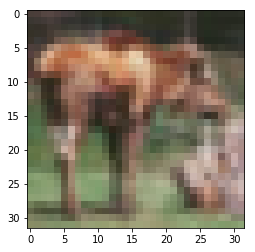

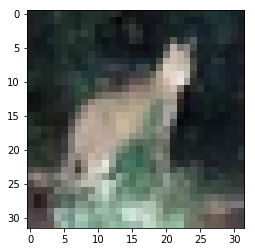

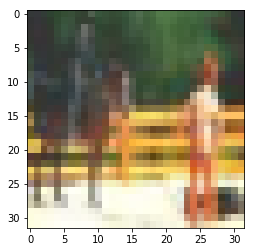

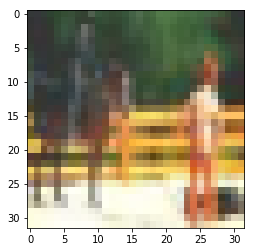

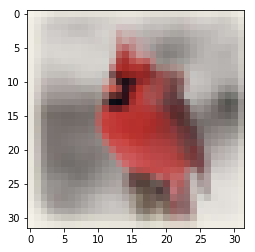

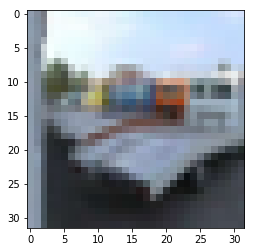

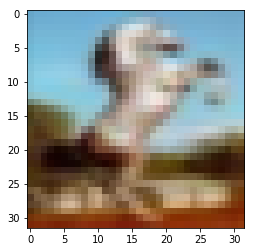

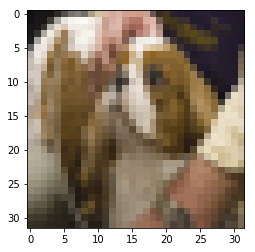

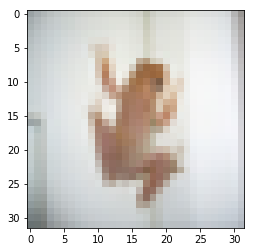

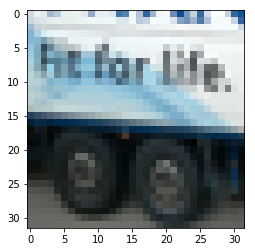

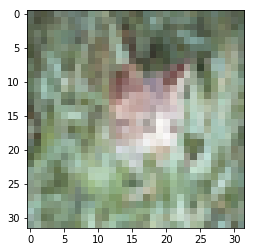

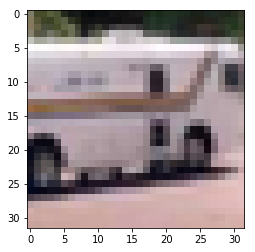

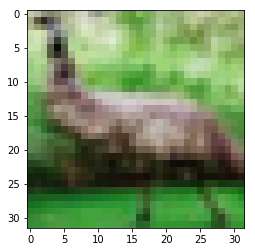

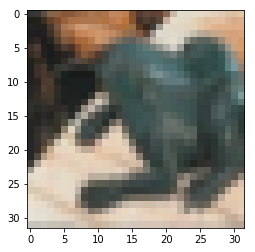

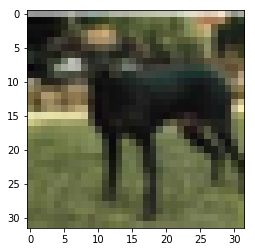

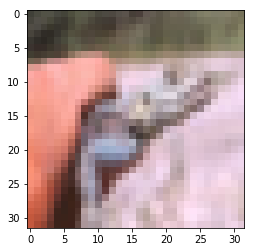

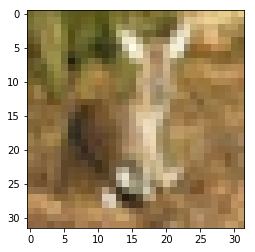

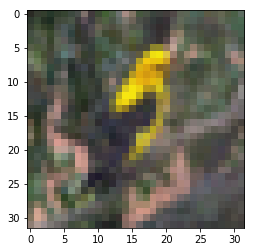

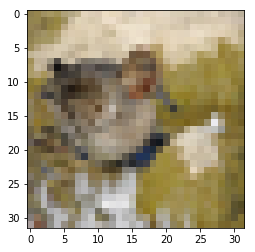

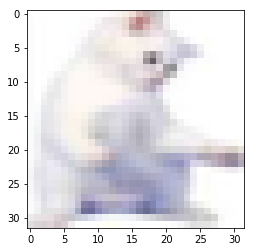

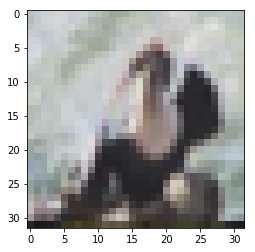

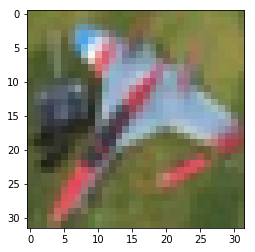

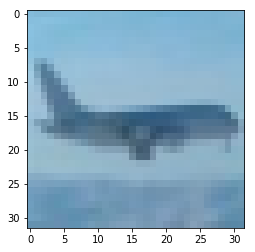

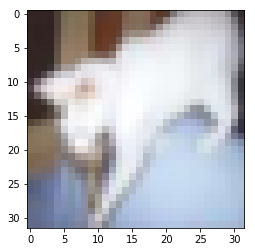

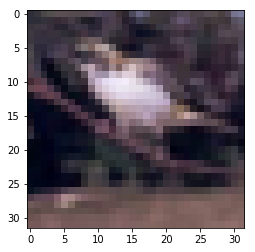

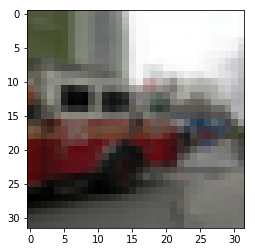

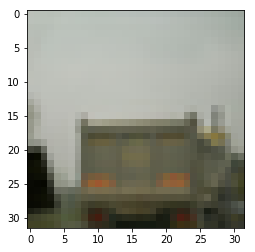

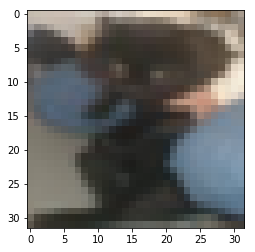

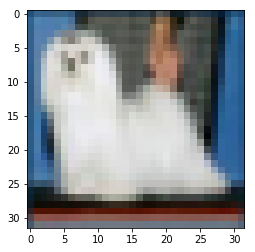

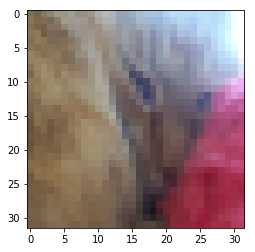

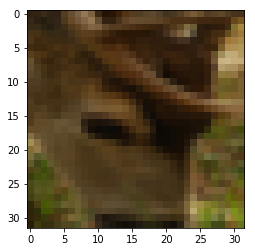

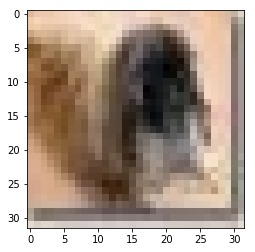

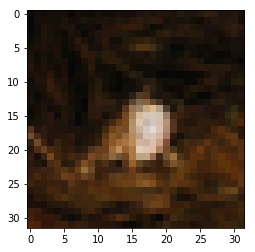

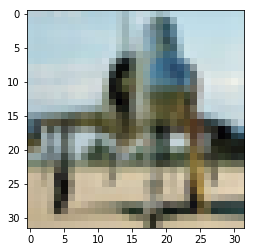

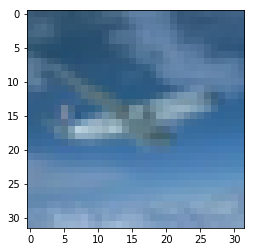

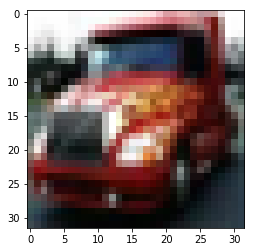

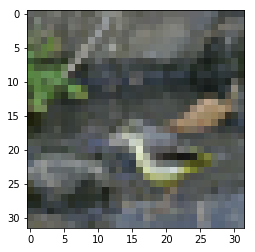

In [27]:
 import random
  
# # fig, ax = plt.subplots(5, 10, figsize = (10,6)) 
# fig, ax = plt.subplots(5, 50, figsize = (50,6)) 
for i in range(50):
  img = test_features[index[random.randint(0,len(index))]]*255
  plt.imshow(img/255)
  plt.show() 
  
#   plt.imshow(superimposed_img)
#   plt.show()

# Generating heatmap from last layer

In [0]:
def getHeatMap(layer,image):
  x = np.expand_dims(image, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(10):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap



##  apply heatmaps on images( first 6 images) and  Visualise on  (GRAD-CAM)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


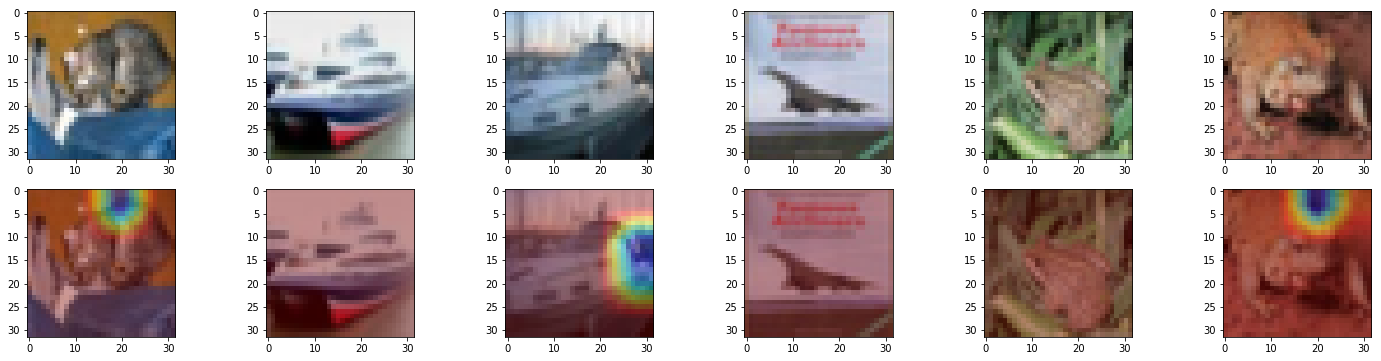

In [0]:
fig, ax = plt.subplots(2, 6, figsize = (25,6))
for i in range(6):
  img = test_features[i]*255
  heatmap = getHeatMap('layer7',img)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img.astype(float), 0.6, heatmap.astype(float), 0.4, 0)
  ax[0, i].imshow(img/255)
  ax[1, i].imshow(superimposed_img/255)
  
plt.show()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
